# SageMaker 내장 XGBoost 훈련 및 추론

In [1]:
import pandas as pd
import numpy as np
from IPython.display import display

In [2]:
%store -r s3_train_path
%store -r s3_val_path
%store -r pre_train_file
%store -r pre_val_file
%store -r pre_test_file

In [3]:
preproc_train_data = pd.read_csv(pre_train_file)
print(f'preproc_train_data: {preproc_train_data.shape}')
preproc_val_data = pd.read_csv(pre_val_file)
print(f'preproc_val_data: {preproc_val_data.shape}')
preproc_test_data = pd.read_csv(pre_test_file)

preproc_train_data: (47023, 126)
preproc_val_data: (13435, 126)


In [4]:
display(preproc_train_data.head())
display(preproc_val_data.head())

,classes,price,freight_value,product_weight_g,product_length_cm,product_height_cm,product_width_cm,customer_state_AC,customer_state_AL,customer_state_AM,...,seller_state_PE,seller_state_PI,seller_state_PR,seller_state_RJ,seller_state_RN,seller_state_RO,seller_state_RS,seller_state_SC,seller_state_SE,seller_state_SP
0,2,69.90,14.25,400.0,21.0,16.0,16.0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,1,359.90,14.42,15700.0,42.0,33.0,42.0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,4,169.00,26.46,250.0,16.0,2.0,11.0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,1,179.00,17.96,2841.0,40.0,23.0,26.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3,115.98,20.00,600.0,19.0,17.0,18.0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


,classes,price,freight_value,product_weight_g,product_length_cm,product_height_cm,product_width_cm,customer_state_AC,customer_state_AL,customer_state_AM,...,seller_state_PE,seller_state_PI,seller_state_PR,seller_state_RJ,seller_state_RN,seller_state_RO,seller_state_RS,seller_state_SC,seller_state_SE,seller_state_SP
0,3,78.0,15.65,250.0,16.0,2.0,20.0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,2,16.9,12.48,410.0,39.0,3.0,28.0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,4,49.3,22.28,250.0,20.0,8.0,11.0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,1,22.0,15.23,225.0,21.0,11.0,16.0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,2,179.9,24.25,5050.0,62.0,6.0,55.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
import os

def save_local_noheader(train_data, validation_data, test_data, preproc_folder):
    train_df = pd.concat([train_data['classes'], train_data.drop(['classes'], axis=1)], axis=1)
    train_file_name = os.path.join(preproc_folder, 'train.csv')
    train_df.to_csv(train_file_name, index=False, header=False)
    print(f'{train_file_name} is saved')

    val_df = pd.concat([validation_data['classes'], validation_data.drop(['classes'], axis=1)], axis=1)
    val_file_name = os.path.join(preproc_folder, 'val.csv')
    val_df.to_csv(val_file_name, index=False, header=False)
    print(f'{val_file_name} is saved')    

    test_df = pd.concat([test_data['classes'], test_data.drop(['classes'], axis=1)], axis=1)
    test_file_name = os.path.join(preproc_folder, 'test.csv')
    test_df.to_csv(test_file_name, index=False)
    print(f'{test_file_name} is saved')        
    
    return train_file_name, val_file_name, test_file_name

preproc_folder = 'preproc_data/feature_engineering/no_header/'
os.makedirs(preproc_folder, exist_ok=True)    
pre_train_file,pre_val_file, pre_test_file = save_local_noheader(preproc_train_data, 
                                                                 preproc_val_data, 
                                                                 preproc_test_data, 
                                                                 preproc_folder)


preproc_data/feature_engineering/no_header/train.csv is saved
preproc_data/feature_engineering/no_header/val.csv is saved
preproc_data/feature_engineering/no_header/test.csv is saved


In [6]:
import sagemaker

sagemaker_session = sagemaker.Session()
bucket = sagemaker.Session().default_bucket()  # replace with an existing bucket if needed
prefix = 'sagemaker/delivery_time'           # prefix used for all data stored within the bucket


# Define IAM role
import boto3
from sagemaker import get_execution_role

role = get_execution_role()



In [7]:
from utils import upload_s3
s3_train_path = upload_s3(bucket, pre_train_file, prefix)
s3_val_path = upload_s3(bucket, pre_val_file, prefix)
print("s3_train_path: ", s3_train_path)
print("s3_val_path: ", s3_val_path)

s3_train_path:  s3://sagemaker-ap-northeast-2-057716757052/sagemaker/delivery_time/preproc_data/feature_engineering/no_header/train.csv
s3_val_path:  s3://sagemaker-ap-northeast-2-057716757052/sagemaker/delivery_time/preproc_data/feature_engineering/no_header/val.csv


In [8]:
s3_input_train = sagemaker.inputs.TrainingInput(s3_data= s3_train_path, content_type='csv')
s3_input_validation = sagemaker.inputs.TrainingInput(s3_data= s3_val_path, content_type='csv')



In [9]:
from sagemaker import image_uris, session
container = image_uris.retrieve("xgboost", session.Session().boto_region_name, version="latest")
print("xgb_image: ", container)

xgb_image:  306986355934.dkr.ecr.ap-northeast-2.amazonaws.com/xgboost:latest


XGBoost 파라미터
- https://github.com/dmlc/xgboost/blob/master/doc/parameter.rst
- https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost_hyperparameters.html

In [10]:
%%time 
sess = sagemaker.Session()

xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    train_instance_count=1, 
                                    train_instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=sess)
xgb.set_hyperparameters(max_depth=6, # default: 6
                        eta=0.3, # learning_rate, default : 0.3
                        alpha = 10, # L1 regularization, default : 0.3
                        gamma=0, # regularization, default : 0
                        colsample_bytree = 0.3,                         
                        min_child_weight=1, # regularization, default: 1, possible: 6
                        subsample=0.8, # default: 1
                        silent=0,
                        num_class = 5,
                        objective='multi:softmax',
                        num_round=100,
                        seed = 1000
                       )

xgb.fit({'train': s3_input_train, 'validation': s3_input_validation})

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


2020-10-25 11:05:43 Starting - Starting the training job...
2020-10-25 11:06:01 Starting - Launching requested ML instances......
2020-10-25 11:07:06 Starting - Preparing the instances for training......
2020-10-25 11:08:06 Downloading - Downloading input data...
2020-10-25 11:08:37 Training - Downloading the training image...
2020-10-25 11:08:57 Training - Training image download completed. Training in progress.Arguments: train
[2020-10-25:11:08:58:INFO] Running standalone xgboost training.
[2020-10-25:11:08:58:INFO] File size need to be processed in the node: 15.71mb. Available memory size in the node: 8473.02mb
[2020-10-25:11:08:58:INFO] Determined delimiter of CSV input is ','
[11:08:58] S3DistributionType set as FullyReplicated
[11:08:58] 47023x125 matrix with 5877875 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2020-10-25:11:08:58:INFO] Determined delimiter of CSV input is ','
[11:08:58] S3DistributionType set as FullyReplicated
[11:08:58] 1

In [13]:
%%time 
xgb_predictor = xgb.deploy(initial_instance_count=1,
                           instance_type='ml.m5.xlarge')

-------------!CPU times: user 200 ms, sys: 13.1 ms, total: 213 ms
Wall time: 6min 31s


In [14]:
from sagemaker.serializers import CSVSerializer
CSVSerializer.ACCEPT = 'text/csv'
xgb_predictor.serializer = CSVSerializer()

In [15]:
test_df = pd.read_csv(pre_test_file, header=None,skiprows=1)
test_df.head()

,0,1,2,3,4,5,6,7,8,9,...,116,117,118,119,120,121,122,123,124,125
0,1,35.00,8.41,350.0,21.0,9.0,13.0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,3,21.99,22.85,300.0,17.0,4.0,12.0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,3,69.90,18.59,125.0,20.0,16.0,19.0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,2,284.90,18.29,610.0,18.0,12.0,18.0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,2,129.90,12.30,1700.0,30.0,35.0,25.0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [16]:
X_test, y_test = test_df.iloc[:,1:], test_df.iloc[:,0]

In [17]:
def predict(data, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, xgb_predictor.predict(array).decode('utf-8')])

    return np.fromstring(predictions[1:], sep=',')

prediction = predict(X_test.to_numpy())

In [18]:
from sklearn.metrics import accuracy_score, f1_score
accuracy = accuracy_score(y_test, prediction)
f1_score = f1_score(y_test, prediction, average='macro')
print("accuracy: %.2f%%" % accuracy)
print("f1_score: %.2f%%" % f1_score)

accuracy: 0.38%
f1_score: 0.31%


[[ 101  389  126   14    1]
 [ 108  599  704  106   10]
 [  39  338 1325  396   51]
 [  14  138  912  469   65]
 [   7   46  392  296   72]]


<Figure size 432x288 with 0 Axes>

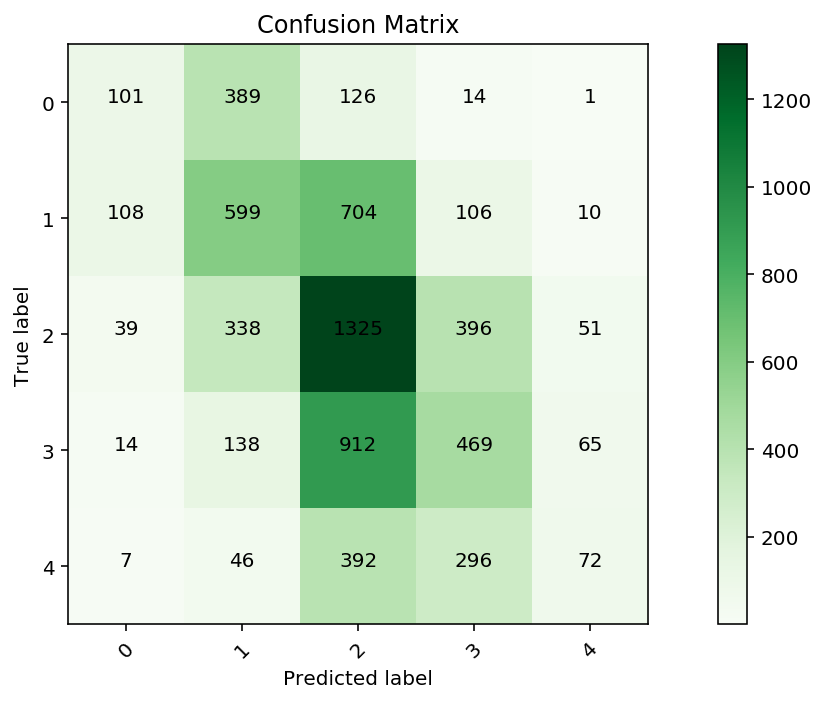

In [19]:
from utils import plot_conf_mat


from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

cm = confusion_matrix(y_true= y_test, y_pred= prediction)

plt.figure()
fig, ax = plt.subplots(figsize=(10,5))
plot_conf_mat(cm, 
              classes=['0','1', '2', '3', '4'], 
              title='Confusion Matrix')
plt.show()